Define Baseline model

The data set will be devided in train - test part. Train till <2017, Test after >=2017

Calculate monthly mean for the train period

Use the monthly mean as a prediction for y_pred

Compare the y_test and y_pred using rmse metric

In [526]:
#!pip install requests
#!pip install sklearn
#!pip install statsmodels
#!pip install pmdarima

In [527]:
# Importing required libraries
import requests
import pandas as pd
import csv
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.facecolor':'white'})

In [528]:
df = pd.read_csv('../Northern.csv',sep=",")
df.head()

,year_x,month_x,day_x,extent,missing,Source Data,datetime,Northern_Hemisphere,Beaufort_Sea,Chukchi_Sea,...,Sea_of_Okhotsk,Yellow_Sea,Cook_Inlet,date,day_y,month_y,year_y,timestamp,dayofyear,hour
0,1978,10,26,10.231,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.26/nt_19...,1978-10-26,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1978,10,28,10.420,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.28/nt_19...,1978-10-28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1978,10,30,10.557,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.10.30/nt_19...,1978-10-30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1978,11,1,10.670,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.01/nt_19...,1978-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1978,11,3,10.777,0.0,['/ecs/DP1/PM/NSIDC-0051.001/1978.11.03/nt_19...,1978-11-03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [529]:
# Split data into train and test set
df_base = df['extent']
train_test_split_ratio = int(len(df_base)*0.8668)
train_data, test_data = df_base[:train_test_split_ratio], df_base[train_test_split_ratio:]


In [530]:
df_base2 = df['datetime']
train_data_x, test_data_x = df_base2[:train_test_split_ratio], df_base2[train_test_split_ratio:]

In [531]:
train_data_x

0        1978-10-26
1        1978-10-28
2        1978-10-30
3        1978-11-01
4        1978-11-03
            ...    
12291    2016-12-27
12292    2016-12-28
12293    2016-12-29
12294    2016-12-30
12295    2016-12-31
Name: datetime, Length: 12296, dtype: object

In [532]:
test_data_x

12296    2017-01-01
12297    2017-01-02
12298    2017-01-03
12299    2017-01-04
12300    2017-01-05
            ...    
14181    2022-03-03
14182    2022-03-04
14183    2022-03-05
14184    2022-03-06
14185    2022-03-07
Name: datetime, Length: 1890, dtype: object

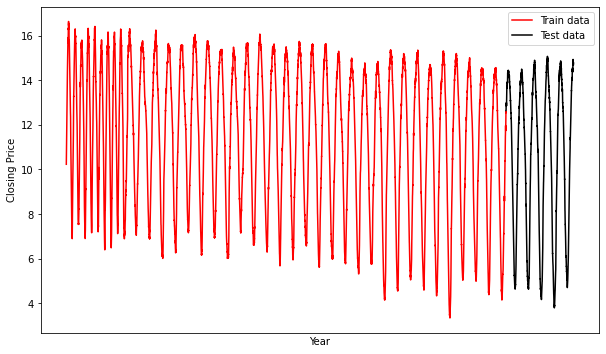

In [533]:
# Plotting the train and test set
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.xticks([])
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();


In [534]:
test_data_x

12296    2017-01-01
12297    2017-01-02
12298    2017-01-03
12299    2017-01-04
12300    2017-01-05
            ...    
14181    2022-03-03
14182    2022-03-04
14183    2022-03-05
14184    2022-03-06
14185    2022-03-07
Name: datetime, Length: 1890, dtype: object

In [535]:
df_train = pd.DataFrame({"extent":train_data,"daytime":train_data_x})
df_test = pd.DataFrame({"extent":test_data,"daytime":test_data_x})
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12296 entries, 0 to 12295
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   extent   12296 non-null  float64
 1   daytime  12296 non-null  object 
dtypes: float64(1), object(1)
memory usage: 192.2+ KB


In [536]:
df_train['datetime'] = pd.to_datetime(df_train['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_train = df_train.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_train.month.describe()

count    12296.000000
mean         6.549203
std          3.447866
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

In [537]:
extent_predict=df_train.groupby('month')['extent'].mean()

In [538]:
extent_predict

month
1     14.258358
2     15.123452
3     15.279789
4     14.556564
5     13.138302
6     11.563613
7      9.150343
8      6.857885
9      6.060819
10     8.018187
11    10.494459
12    12.688589
Name: extent, dtype: float64

In [539]:
df_test['datetime'] = pd.to_datetime(df_test['daytime'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_test = df_test.assign(
    timestamp = lambda x: pd.to_datetime(x['datetime']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)
df_test.to_csv('Test.csv', encoding='utf-8', index=False)

In [540]:
df_observ_x =df_test['extent']
df_observ_time=df_test['timestamp']


In [541]:
#data_month = df_train.resample('M', on='month').mean()
#df_pred =[df_test['datetime'],df_test['year'],df_test['month'], df_test['day'],df_test['extent']]
for months in range(1,13):
    for ind in range(12296,12296+len(df_test['month'])):
        if df_test['month'][ind]==months:
           # print(ind, df_test['extent'][ind],extent_predict[months])
           #df_test['extent'][i] = extent_predict[months]
           #print(df_test['extent'][i], extent_predict[months])
            df_test['extent'][ind] = extent_predict[months]
           



In [542]:
#df_pred.tail(50)#

In [543]:
extent_predict

month
1     14.258358
2     15.123452
3     15.279789
4     14.556564
5     13.138302
6     11.563613
7      9.150343
8      6.857885
9      6.060819
10     8.018187
11    10.494459
12    12.688589
Name: extent, dtype: float64

In [544]:
df_test

,extent,daytime,datetime,timestamp,year,month,day
12296,14.258358,2017-01-01,2017-01-01,2017-01-01,2017,1,1
12297,14.258358,2017-01-02,2017-01-02,2017-01-02,2017,1,2
12298,14.258358,2017-01-03,2017-01-03,2017-01-03,2017,1,3
12299,14.258358,2017-01-04,2017-01-04,2017-01-04,2017,1,4
12300,14.258358,2017-01-05,2017-01-05,2017-01-05,2017,1,5
...,...,...,...,...,...,...,...
14181,15.279789,2022-03-03,2022-03-03,2022-03-03,2022,3,3
14182,15.279789,2022-03-04,2022-03-04,2022-03-04,2022,3,4
14183,15.279789,2022-03-05,2022-03-05,2022-03-05,2022,3,5
14184,15.279789,2022-03-06,2022-03-06,2022-03-06,2022,3,6


In [545]:
df_test['extent']

12296    14.258358
12297    14.258358
12298    14.258358
12299    14.258358
12300    14.258358
           ...    
14181    15.279789
14182    15.279789
14183    15.279789
14184    15.279789
14185    15.279789
Name: extent, Length: 1890, dtype: float64

In [546]:
#df_pred['extent']

In [547]:
df_test_observ

<bound method NDFrame.copy of           extent     daytime   datetime  timestamp  year  month  day
12296  14.258358  2017-01-01 2017-01-01 2017-01-01  2017      1    1
12297  14.258358  2017-01-02 2017-01-02 2017-01-02  2017      1    2
12298  14.258358  2017-01-03 2017-01-03 2017-01-03  2017      1    3
12299  14.258358  2017-01-04 2017-01-04 2017-01-04  2017      1    4
12300  14.258358  2017-01-05 2017-01-05 2017-01-05  2017      1    5
...          ...         ...        ...        ...   ...    ...  ...
14181  15.279789  2022-03-03 2022-03-03 2022-03-03  2022      3    3
14182  15.279789  2022-03-04 2022-03-04 2022-03-04  2022      3    4
14183  15.279789  2022-03-05 2022-03-05 2022-03-05  2022      3    5
14184  15.279789  2022-03-06 2022-03-06 2022-03-06  2022      3    6
14185  15.279789  2022-03-07 2022-03-07 2022-03-07  2022      3    7

[1890 rows x 7 columns]>

In [548]:
df_observ_x

12296    14.258358
12297    14.258358
12298    14.258358
12299    14.258358
12300    14.258358
           ...    
14181    15.279789
14182    15.279789
14183    15.279789
14184    15.279789
14185    15.279789
Name: extent, Length: 1890, dtype: float64

In [549]:
#df_pred['extent']

In [550]:
df_obs = pd.read_csv('../Test.csv',sep=",")

In [551]:
df_obs.head()

,extent,daytime,datetime,timestamp,year,month,day
0,12.643,2017-01-01,2017-01-01,2017-01-01,2017,1,1
1,12.644,2017-01-02,2017-01-02,2017-01-02,2017,1,2
2,12.713,2017-01-03,2017-01-03,2017-01-03,2017,1,3
3,12.954,2017-01-04,2017-01-04,2017-01-04,2017,1,4
4,12.956,2017-01-05,2017-01-05,2017-01-05,2017,1,5


In [552]:
df_observ_x

12296    14.258358
12297    14.258358
12298    14.258358
12299    14.258358
12300    14.258358
           ...    
14181    15.279789
14182    15.279789
14183    15.279789
14184    15.279789
14185    15.279789
Name: extent, Length: 1890, dtype: float64

In [553]:
df_obs.extent

0       12.643
1       12.644
2       12.713
3       12.954
4       12.956
         ...  
1885    14.703
1886    14.748
1887    14.762
1888    14.756
1889    14.769
Name: extent, Length: 1890, dtype: float64

In [554]:
rmse_baseline = sqrt(mean_squared_error(df_observ_x, df_obs['extent']))
print("Baseline RMSE : " + str(round(rmse_baseline,3)))

Baseline RMSE : 1.28
